## Load basic libraries

Including Numpy, PIL, PyTorch, torchvision, CapTum and in-house classes

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from torchvision import models
from torch.autograd import Variable

import torch
import torch.nn as nn
from torch.nn import functional as func

from torchsummary import summary

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import Deconvolution
from captum.attr import GuidedGradCam

from asdeep.dataset import ASEDataset
from asdeep.dataset import MultipleTestAdjustment
from asdeep.database import HilbertCurve

In [2]:
def plot_attr_mtrx(orig,
                   attr_map,
                   target_cmap,
                   overlay_cmap,
                   figwidth=25,
                   figheight=7):
    '''Draw a heatmap to show the attribution of different interpration approaches.'''
    fig, axes = plt.subplots(2, len(attr_map)+1)

    res_axes = axes[0][0].set_axis_off()
    axes[0][0].annotate("Helbert curve of DNA sequence", (.5, .5),
                        ha="center", fontsize="xx-large")
    axes[1][0].imshow(orig.squeeze().cpu().detach().numpy(),
                      alpha=1.0, cmap=target_cmap)
    axes[1][0].set_axis_off()

    for idx, (method, attr) in enumerate(attr_map.items()):
        idx += 1
        axes[0][idx].imshow(attr.squeeze().cpu().detach().numpy(),
                            alpha=1.0, cmap=overlay_cmap)
        axes[0][idx].set_axis_off()
        axes[0][idx].set_title(method)

        axes[1][idx].imshow(orig.squeeze().cpu().detach().numpy(),
                            alpha=1.0, cmap=target_cmap)
        axes[1][idx].imshow(attr.squeeze().cpu().detach().numpy(),
                            alpha=0.5, cmap=overlay_cmap)
        axes[1][idx].set_axis_off()

    fig.set_figwidth(figwidth)
    fig.set_figheight(figheight)
    fig.set_tight_layout(tight=True)
    
    return (fig, axes)

In [3]:
def attrmtrx_to_attrseq(hbcv: HelbertCurve,
                        attr_dict: dict,
                        scale_hbcv: bool =True,
                        biallelic: bool =True):
    '''Converts attributions of the Helbert curve matrix into a sequence.
    
    Args:

    Returns:
        A named numpy.narray of attributions from given attibution matrix. The
        results include all attributions given by attr_dict as well as the code
        of Helbert curve matrix.

    Raises:
        None
    '''
    hbcv_mtrx = hbcv.get_hcurve(onehot=False).squeeze()
    
    if scale_hbcv: hbcv_mtrx *= 1.0 / hbcv_mtrx.max()
    
    n_elements = np.prod(hbcv_mtrx.shape)  # Number of elements in the matrix
    
    attr_dtype = [('OS', '>f8')] + [(k, '>f8') for k in attr_dict.keys()]
    attr_seq = np.zeros(n_elements, dtype=attr_dtype)
    for idx, (i, j) in enumerate(zip(hbcv.y_pool, hbcv.x_pool)):
        i, j = int(i), int(j)
        attr_seq['OS'][idx] = hbcv_mtrx[i][j]
        for key, val in attr_dict.items():
            attr_seq[key][idx] = val[i][j]

    if biallelic:
        allele_len = int(n_elements / 2)
        attr_biseq = np.zeros((allele_len, 2), dtype=attr_dtype)
        for key, _ in attr_dtype:
            attr_biseq[key][:, 0] = attr_seq[key][:allele_len][::-1]
            attr_biseq[key][:, 1] = attr_seq[key][allele_len:]
        
        return attr_biseq
        
    return attr_seq


def plot_attrseq(attrs, colors=('r', 'b'), figwidth=15, figheight=5):
    '''Draw a line plot to show the attribution of the n-mer along the sequence.
    Args:
      attrs:
        A numpy.narray of attributions with type of attribution as name and 
        attributions sequence as value. The attribution sequences should be
        splited into two alleles.

    Returns:
      A tuple including matplotlib.pyplot.Figure and matplotlib.pyplot.axes.

    Raises:
      ValueError:
        A error occur when the sequence of Helbert curve not splited into
        sequences of two allele.
    '''
    seqlen, n_allele = attrs.shape
    if n_allele != 2:
        raise ValueError("The sequence should be splited into two allele!")
    
    # Check if there is any heterzygous sites.
    heter_sites = (attrs['OS'][:, 0] != attrs['OS'][:, 1]).nonzero()
    if heter_sites[0].size < 1:
        heter_sites = None
    else:
        heter_sites = heter_sites[0]            
    
    # plot sequence
    attr_names = attrs.dtype.names
    
    n_attrs = len(attr_names)
    fig, axes = plt.subplots(n_attrs * 2)

    x_sequence = np.arange(seqlen)
    for idx, attr_name in enumerate(attr_names):
        _a_idx, _b_idx = idx * 2, idx * 2 + 1
        axes[_a_idx].plot(x_sequence, attrs[attr_name][:, 0], linewidth=1, color=colors[0])
        axes[_a_idx].set_ylabel('{}-A{}'.format(attr_name, "A"), va='top')
        
        axes[_b_idx].plot(x_sequence, attrs[attr_name][:, 1], linewidth=1, color=colors[1])
        axes[_b_idx].set_ylabel('{}-A{}'.format(attr_name, "B"), va='top')
        
        if heter_sites is not None and heter_sites.size > 0:
            axes[_a_idx].scatter(heter_sites, np.zeros(len(heter_sites)), marker='.', color='r')
            axes[_b_idx].scatter(heter_sites, np.zeros(len(heter_sites)), marker='.', color='r')
         
        axes[_a_idx].spines.bottom.set_visible(False)
        axes[_a_idx].set_xticks([])        
        if _b_idx < (n_attrs - 1) * 2:
            axes[_b_idx].spines.bottom.set_visible(False)
            axes[_b_idx].set_xticks([])

        axes[_a_idx].spines.top.set_visible(False)
        axes[_a_idx].spines.right.set_visible(False)
        axes[_b_idx].spines.top.set_visible(False)
        axes[_b_idx].spines.right.set_visible(False)
    
    fig.set_figwidth(figwidth)
    fig.set_figheight(figheight)
    fig.set_tight_layout(True)
    fig.align_ylabels()
    
    return (fig, axes)

In [ ]:
def fetch_layer_by_path(model: torch.nn.Module, layer_path: str ='.layer4[-1].conv3'):
    '''Fetch a layer of toch.nn.Module by a access path'''
    per_access = re.findall('\.\w+|\[-?\d+\]', layer_path)
    
    if len(per_access) == 0:
        return model

    for item in per_access:
        if item.startswith('.'):
            model = getattr(model, item.replace('.', '', 1))
        elif item.startswith('['):
            model = model[int(item.replace('[', '').replace(']', ''))]
        else:
            raise ValueError("Unknown pattern was found: " + item)
    
    return model            

## Prepare a input matrix

The input sequence was selected arbitrarily.

In [4]:
file_path_pool = ['../outputs/allelic_read_counts/PAN/optDir/BC2ATKACXX-4-5/aseqOptDir/BC2ATKACXX-4-5-dup-train-set.fa']
gene_id = ['ENSG00000108405', 'ENSG00000127507', 'ENSG00000090382']
my_asedataset = ASEDataset(gene_id, file_path_pool,
                           SeqToHelbertAndMakeLabel(onehot=False, matrix=False),
                           MultipleTestAdjustment())
hcurve, true_label = my_asedataset[2]
matrix = hcurve.get_hcurve(onehot=False)
matrix = Variable(torch.Tensor(np.expand_dims(matrix, 0)))

## Then load the pre-trained model

This model was trained on three genes (same as the input matrix). Its archtecture was a modified ResNext in which one Conv2D layer was added as the input layer and a fully-connected Linear layer was attached for the trilabel classification.

In [5]:
model_state = '../outputs/aseModels/bios/20210430_004202_pytorch-model.pth'

net = models.resnext50_32x4d()
net.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
net.fc = nn.Linear(2048, 3)
net.load_state_dict(torch.load(model_state, map_location='cpu'))
net = net.eval()

In [6]:
output = net(matrix)
output = func.softmax(output, dim=1)
pred_score, pred_idx = torch.topk(output, 1)
print('{}, {}, {}'.format(pred_score.squeeze().cpu().detach().numpy(), pred_idx.squeeze().cpu().detach().numpy(), true_label))

0.8756615519523621, 1, 1


## Gradient-based attribution

The step was following the guide by [Captum](https://captum.ai/tutorials/Resnet_TorchVision_Interpret).
First, the attributions by Integrated Gradients was calculated by the implementation named `IntegratedGradients` in Captum.

In [7]:
integraded_gratients = IntegratedGradients(net)
attr_ig = integraded_gratients.attribute(matrix, target=pred_idx, n_steps=200)

Also, the `GradientShap` was implemented as a linear explanation model which uses a distribution of reference samples to explain predictions of the model.

In [8]:
rand_mtrx_dist = torch.cat([matrix * 0, matrix * 1, matrix * 2])
gradient_shap = GradientShap(net)
attr_gs = gradient_shap.attribute(matrix, n_samples=50,
                                  baselines=rand_mtrx_dist,
                                  target=pred_idx)

Another different approache is to estimate which areas of the input are critical for the classifier's decision by occuluding them and quantifying how the decision changes. The algorithm was implemented as `Occlusion`.

In [9]:
occlusion = Occlusion(net)
attr_occ = occlusion.attribute(matrix,
                               strides=(1, 1, 1),
                               target=pred_idx,
                               sliding_window_shapes=(1, 4, 4),
                               baselines=0)

In [10]:
deconvolution = Deconvolution(net)
attr_dcv = deconvolution.attribute(matrix, target=pred_idx)

/home/umcg-zzhang/Documents/projects/wp_ase_dlp/scripts/.env/lib/python3.7/site-packages/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/home/umcg-zzhang/Documents/projects/wp_ase_dlp/scripts/.env/lib/python3.7/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:61: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."
/home/umcg-zzhang/Documents/projects/wp_ase_dlp/scripts/.env/lib/python3.7/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full

In [11]:
guidedgradcam = GuidedGradCam(net, net.layer4[-1].conv2)
attr_gdc = guidedgradcam.attribute(matrix, target=pred_idx)

Then, plot the attribution by coverint it on the real image.

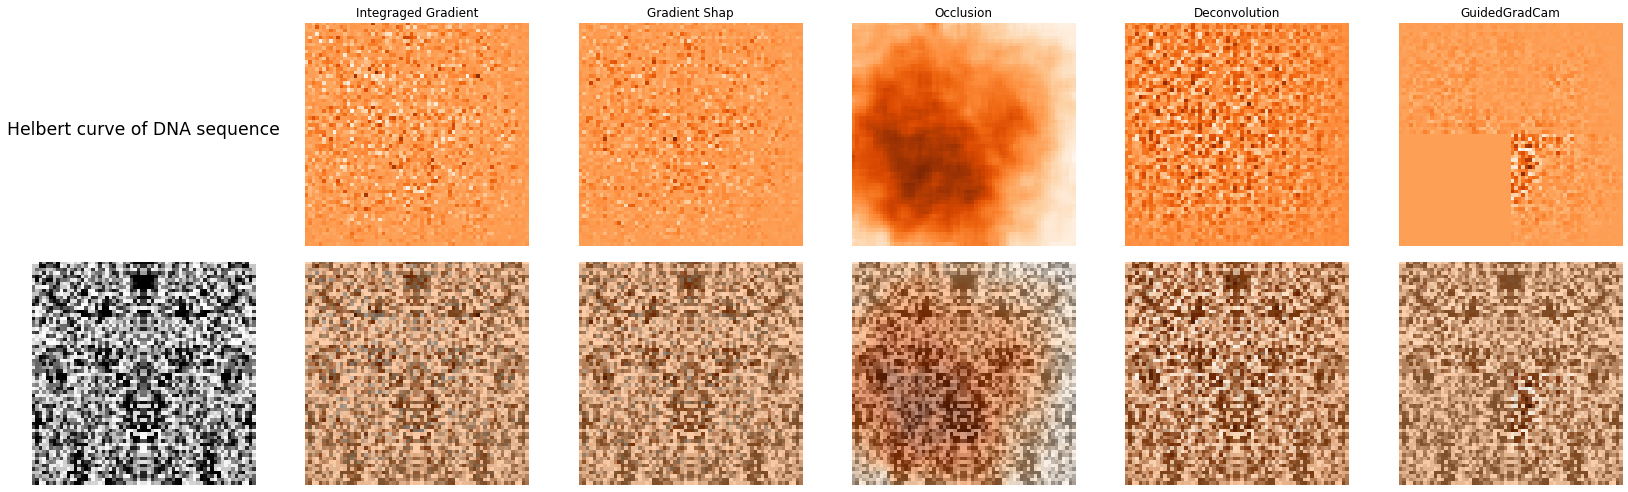

In [12]:
attr_list = {'Integraged Gradient': attr_ig,
             'Gradient Shap': attr_gs,
             'Occlusion': attr_occ,
             'Deconvolution': attr_dcv,
             'GuidedGradCam': attr_gdc}
_ = plot_attr_mtrx(matrix, attr_list, 'Greys', 'Oranges', 23, 7)

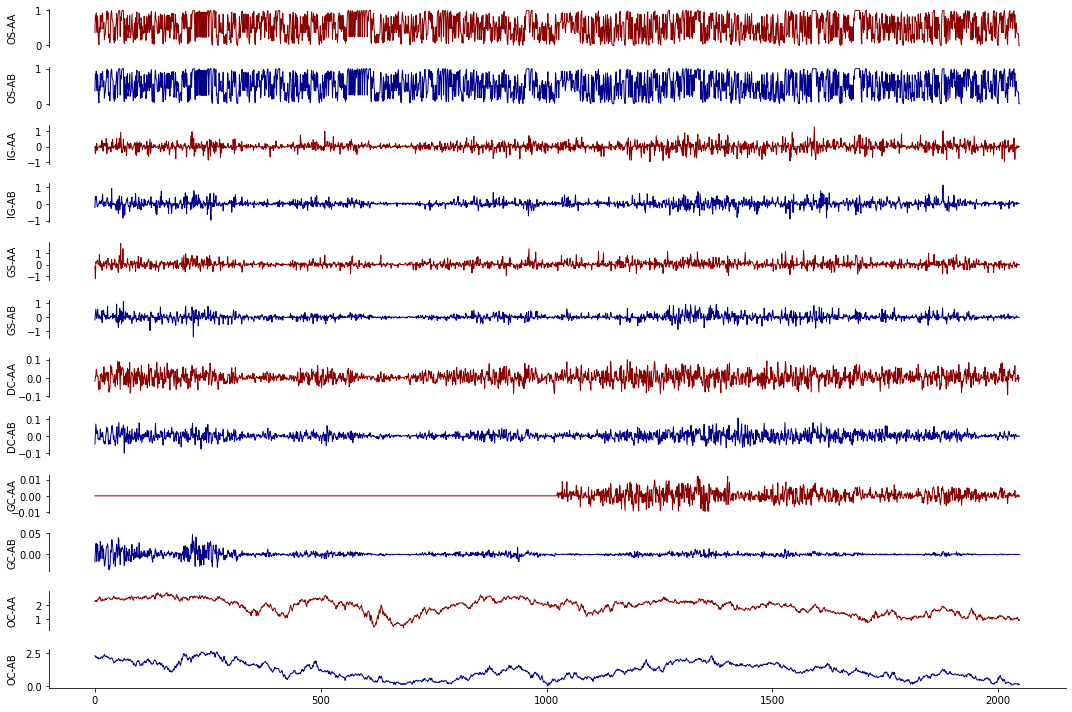

In [13]:
attrseq = attrmtrx_to_attrseq(hcurve, {'IG': attr_ig.squeeze().cpu().detach().numpy(),
                                       'GS': attr_gs.squeeze().cpu().detach().numpy(),
                                       'DC': attr_dcv.squeeze().cpu().detach().numpy(),
                                       'GC': attr_gdc.squeeze().cpu().detach().numpy(),
                                       'OC': attr_occ.squeeze().cpu().detach().numpy(),})
_ = plot_attrseq(attrseq, ('darkred', 'darkblue'), figheight=10)

In [115]:
from itertools import product
index = list(product([0, 1], repeat=3))

myzeros = np.zeros((3, 3), dtype=[('a', '>f8'), ('b', '>f8')])
myzeros['a'] = np.ones((3, 3))
myzeros['b'] = np.array([1, 2, 3]).reshape((3, 1))
myzeros['a'][:, :2]

array([[1., 1.],
       [1., 1.],
       [1., 1.]])

In [21]:
x = torch.rand(3, requires_grad=True)
y = x**2
z = x+x
z.sum().backward()


tensor([0.0340, 0.5795, 0.8792], grad_fn=<AddBackward0>)